## Random Forest

* In this section, random forest will be utilized to **predict** the **LogP** value. 


* Additionally, we will explore how the inclusion of **polynomial and rational difference features** can enhance the model's performance. One of the goals of this study is to compare how well different models (linear regression, random forest, neural networks) manage with reproducing those features.


* The model's performance will also be refined through **regularization** and **feature selection** (SelectKBest, Recursive Feature Elimination).


* For models with a large number of features, we will utilize **Principal Component Analysis (PCA) to decrease dimensionality**, aiming to enhance the generalization performance of the models.


* At the end, a summary of the model's performance at different levels of complexity will be provided.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modules for data preprocessing and feature engineering
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression, mutual_info_regression

# modules for model selection and evaluation
from sklearn.model_selection import KFold, cross_validate, GridSearchCV#, cross_val_score  
from sklearn.metrics import mean_squared_error, r2_score

# modules for building the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Import Principal Component Analysis module
from sklearn.decomposition import PCA

# saving sklearn models
import joblib

import performance_metrics as pm

### Dataset

To begin, we will import the train-validation and test sets. In the test set, 20% of the original dataset is kept for the final evaluation of the model's performance and for making comparisons between various models.

In [2]:
# import training-validation set and test set
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# separate the datasets into features and the target variables
X_train = df_train.drop('logp', axis=1)
y_train = df_train['logp']

X_test = df_test.drop('logp', axis=1)
y_test = df_test['logp']

In [4]:
print(f'The size of the \033[1mtrain set\033[0m is: \033[1m{len(X_train)}\033[0m and the size of the \033[1mtest set\033[0m is: \033[1m{len(X_test)}\033[0m')

The size of the train set is: 49094 and the size of the test set is: 12274


In [5]:
# list of original features
original_features = ['mwt', 'rings', 'heavy_atoms', 'hetero_atoms', 'fraction_sp3',
       'charge1', 'Hbond_donors1', 'Hbond_acceptors1', 'rotatable_bonds1',
       'apolar_des1', 'polar_des1', 'RDtpsa', 'RDCfraction']

### 1. Baseline Random Forest Model ###

To establish a baseline for tracking changes in the model's performance, particularly with the addition of engineered features, we'll begin with a basic model that utilizes only the original features.

In [6]:
# random forest model
rf_model = RandomForestRegressor()

Let's begin by **fine-tuning the essential hyperparameters** of the random forest regressor.

In [7]:
# range of hyperparameter values to be tested
parameters = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [2, 3, 4, 5], # values within the range from log2 to square root
    'bootstrap': [True, False]
} 

The size of each fold used in cross-validation throughout this study will be approximately 5000 samples.

In [8]:
# dividing the training-validation dataset into 10 folds
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In this study, **GridSearchCV** is utilized for hyperparameter tuning and evaluating models' performance. The **scoring** methods chosen for this purpose are **Mean Squared Error (MSE) and R-squared (R²)**. The best model will be selected based on the MSE score.

In [9]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'R-squared': 'r2'
}

Let's fine-tune the hyperparameters.

In [10]:
#grid_basic = GridSearchCV(rf_model, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X_train[original_features], y_train)

In [11]:
# save the GridSearchCV results
#joblib.dump(grid_basic, 'models/RF_basic_grid_result_extended.joblib')

In [12]:
# load the results
grid_basic = joblib.load('models/RF_basic_grid_result_extended.joblib')

The **best parameters** are as follows.

In [13]:
# the best parameters
best_params = grid_basic.best_params_
best_params

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [14]:
# dataframe with the GridSearchCV results
results = pd.DataFrame(grid_basic.cv_results_)

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.8971 (0.0020)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1596 (0.0029)


To gain a deeper insight into how parameter choices impact the performance of the random forest model, let's **visualize the performance across various combinations of parameters**.

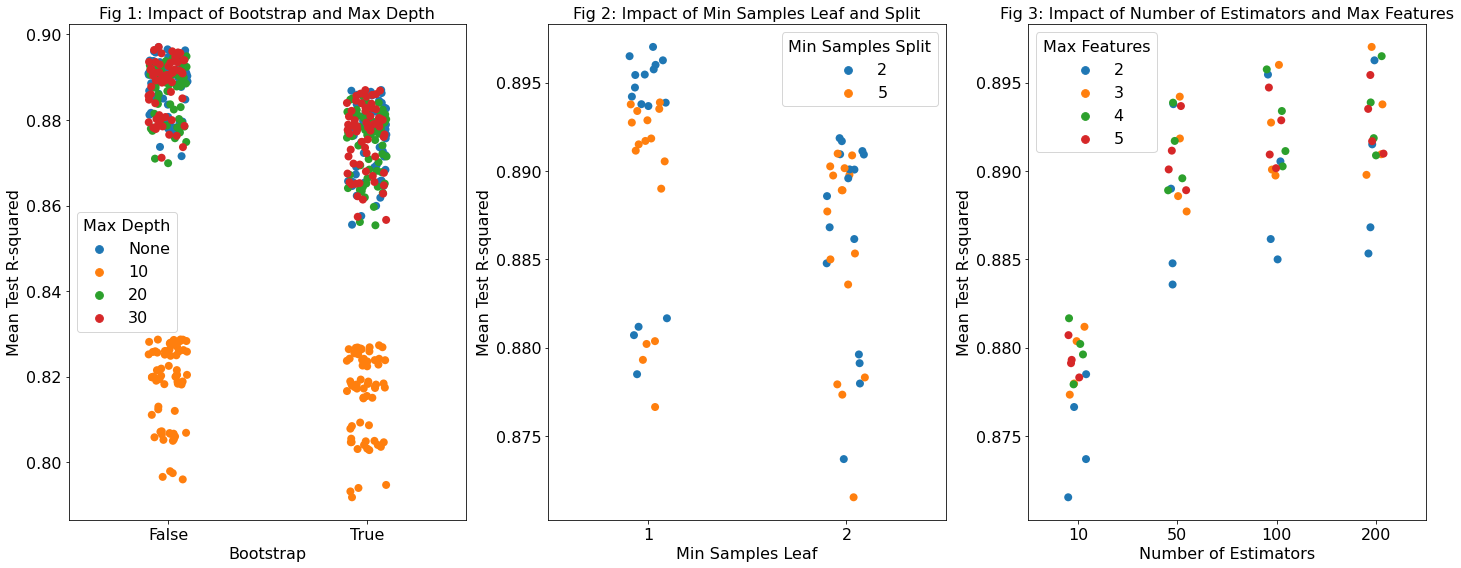

In [15]:
# create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# fig 1: Impact of Bootstrap and Max Depth
results['param_max_depth'] = results['param_max_depth'].astype(str)
sns.stripplot(data=results, x='param_bootstrap', y='mean_test_R-squared', hue='param_max_depth', ax=ax1, size=8)
ax1.set_title('Fig 1: Impact of Bootstrap and Max Depth', fontsize=16)
ax1.set_xlabel('Bootstrap', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Max Depth', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)

# fig 2: Impact of Min Samples Leaf and Split
filtered_results = results[(results['param_bootstrap'] == False) & (results['param_max_depth'] == 'None')]
sns.stripplot(data=filtered_results, x='param_min_samples_leaf', y='mean_test_R-squared', hue='param_min_samples_split', ax=ax2, size=8)
ax2.set_title('Fig 2: Impact of Min Samples Leaf and Split', fontsize=16)
ax2.set_xlabel('Min Samples Leaf', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
legend2 = ax2.legend(title='Min Samples Split', fontsize=16)
legend2.get_title().set_fontsize(16) 
ax2.tick_params(axis='both', labelsize=16)

# fig 3: Impact of Number of Estimators and Max Features
sns.stripplot(data=filtered_results, x='param_n_estimators', y='mean_test_R-squared', hue='param_max_features', ax=ax3, size=8)
ax3.set_title('Fig 3: Impact of Number of Estimators and Max Features', fontsize=16)
ax3.set_xlabel('Number of Estimators', fontsize=16)
ax3.set_ylabel('Mean Test R-squared', fontsize=16)
legend3 = ax3.legend(title='Max Features', fontsize=16)
legend3.get_title().set_fontsize(16)  
ax3.tick_params(axis='both', labelsize=16)

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

In Fig 1, the model consistently **performs better without bootstrapping**. Additionally, its performance suffers when the maximum tree depth is set to 10, while it exhibits significantly higher performance with a **max depth of 20, 30, or without limitation**, showing comparable results for these scenarios.

Fig 2 reveals that the model performs better when **each leaf can contain even just one sample**, and the optimal minimum number of samples required to split an internal node is found to be two.

In Fig 3, the model's performance shows a positive trend with an increasing number of estimators. However, the performance improvement becomes less pronounced for the last two points, indicating a plateau. While **further increasing the number of estimators (over 200) could slightly enhance performance, it would come at a substantial computational cost**. Additionally, the plot illustrates that the model's performance is lowest when the **maximum number of features considered for the best split** is at its minimum. Notably, for **3 features**, the results are slightly better than for 4 and 5 features.

To **assess the model's performance on entirely unseen data**, we will train the model using the complete training-validation dataset and make predictions for the target values.

In [16]:
# fit the the best pipeline on the whole training-validation set
best_pipe_basic = grid_basic.best_estimator_
best_pipe_basic.fit(X_train[original_features], y_train)

# predict the target values for both the training-validation and test sets
y_train_pred = best_pipe_basic.predict(X_train[original_features])
y_test_pred = best_pipe_basic.predict(X_test[original_features])

In [17]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train[original_features])

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 1.0000)
Test set adjusted R2 score: 0.9008)

Training set MSE score: -0.0000)
Test set MSE score: -0.1581)


The metrics obtained just above for the unseen data, as well as those obtained during GridSearchCV a few lines earlier, provide us with a **baseline for the model's performance**.


To simplify the comparison of model performance at various stages of model development, let's consolidate all the metrics into a single dataframe.

In [18]:
# make a dataframe which stores the performance metrics
index = pd.MultiIndex.from_tuples([('Train', 'CV_R2'), ('Train', 'CV_R2_std'), ('Train', 'CV_MSE'), ('Train', 'CV_MSE_std'), ('Train', 'Adjusted R2'), ('Train', 'MSE'), ('Test', 'CV_R2'), ('Test', 'CV_R2_std'), ('Test', 'CV_MSE'), ('Test', 'CV_MSE_std'), ('Test', 'Adjusted R2'), ('Test', 'MSE')], names=['Set', 'Scoring'])
RF_scores = pd.DataFrame(index=index)

In [19]:
def add_scores(column_name):
    """
    the function adds performance metrics calculated before to a dataframe
    """
    RF_scores[column_name] = [pm.CV_train_R2, pm.CV_train_R2_std, pm.CV_train_MSE, pm.CV_train_MSE_std, pm.train_adjusted_R2, pm.train_MSE, pm.CV_test_R2, pm.CV_test_R2_std, pm.CV_test_MSE, pm.CV_test_MSE_std, pm.test_adjusted_R2, pm.test_MSE]

Now, let's integrate the scores of our basic model into the dataframe. We will utilize them later to make comparisons between various models.

In [20]:
add_scores('baseline')

As the final step, let's **visualize how well the model predicts** the values by plotting them alongside the actual values.

Visual representation of the model's fit to the **training-validation set**.

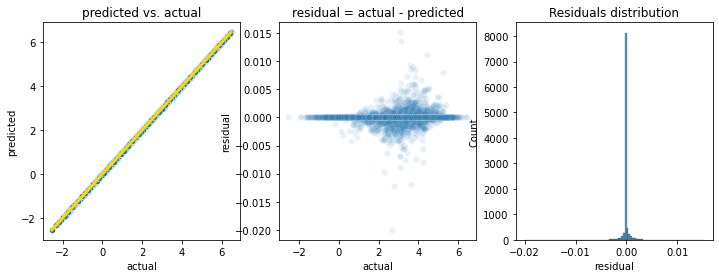

In [21]:
pm.visualize_fit(y_train, y_train_pred)

Visual representation of the model's fit to the **unseen test set**.

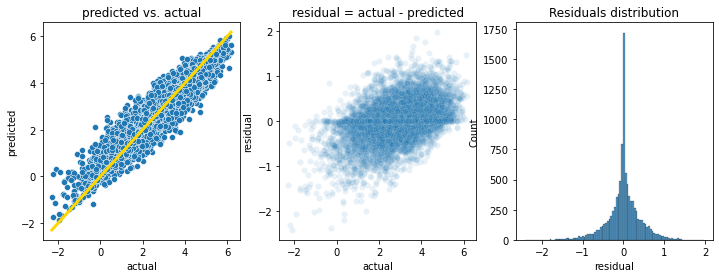

In [22]:
pm.visualize_fit(y_test, y_test_pred)

The model demonstrates an excellent fit to the training set and maintains a high level of performance on the test set. The histograms of residuals exhibit a dirac delta shape, indicating precise predictions for the majority of values. Yet, a **discernible pattern emerges when inspecting the residual versus actual value plot** for the test set. This pattern suggests that the **existing independent variables fall short of capturing the complete deterministic component**. To address this challenge, one potential approach is to explore the generation of supplementary features and integrate them into the model.

### 2. Refined Random Forest Model

As highlighted in the earlier section, an approach to **enhance the model** involves **broadening the feature set through engineering**. We will delve into features identified during Exploratory Data Analysis, encompassing polynomial, rational difference, and power-transformed features. To gain a clearer understanding of their impact on the model, we will **introduce each type of feature one at a time**.

### 2A. Polynomial features ###

### _2A.1 Polynomial features_ ###

While incorporating polynomial features into a Random Forest model is typically unnecessary due to its inherent capability to capture non-linear patterns, we have two specific reasons for doing so:
* PolynomialFeatures() generates not only squared (_$a^2$_), cubic (_$a^3$_)  or in general _$a^n$_ features, which might be redundant for the Random Forest model, but also cross-product features (_$a*b$_).
* We aim to assess and compare the performance of various algorithms (Linear Regression, Random Forests, Neural Networks) in handling the reproduction of different types of features.

In [23]:
# include polynomial features
steps = list()
steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
steps.append(('model', rf_model))
pipeline = Pipeline(steps=steps)

During the exploratory data analysis, it was evident that certain data would benefit from fitting with a **second-degree polynomial**, while others would benefit from a **third-degree polynomial**. Now, let's **fine-tune this parameter using GridSearchCV**.

In [24]:
# refine the polynomial order and tune hyperparameters specific to Random Forest
parameters = {
    'poly__degree': [2, 3],
    'model__n_estimators': [200],
    'model__max_depth': [None, 20, 30],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False]
} 

In [25]:
#grid_poly = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X_train[original_features], y_train)

In [26]:
# save the GridSearchCV results
#joblib.dump(grid_poly, 'models/RF_poly_grid_result_extension.joblib')

In [27]:
# load the results
grid_poly = joblib.load('models/RF_poly_grid_result_extension.joblib')

Let's analyze the **results of the optimization**. The identified optimal parameters are as follows:

In [28]:
# the best parameters
best_params = grid_poly.best_params_
best_params

{'model__bootstrap': False,
 'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 200,
 'poly__degree': 2}

In [29]:
# summary of the GridSearchCV
results = joblib.load('models/RF_poly_grid_results_all.joblib')

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.8961 (0.0020)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1611 (0.0028)


To gain a deeper insight into how parameter choices impact the performance of the random forest model, let's **visualize the performance across various combinations of parameters**.|

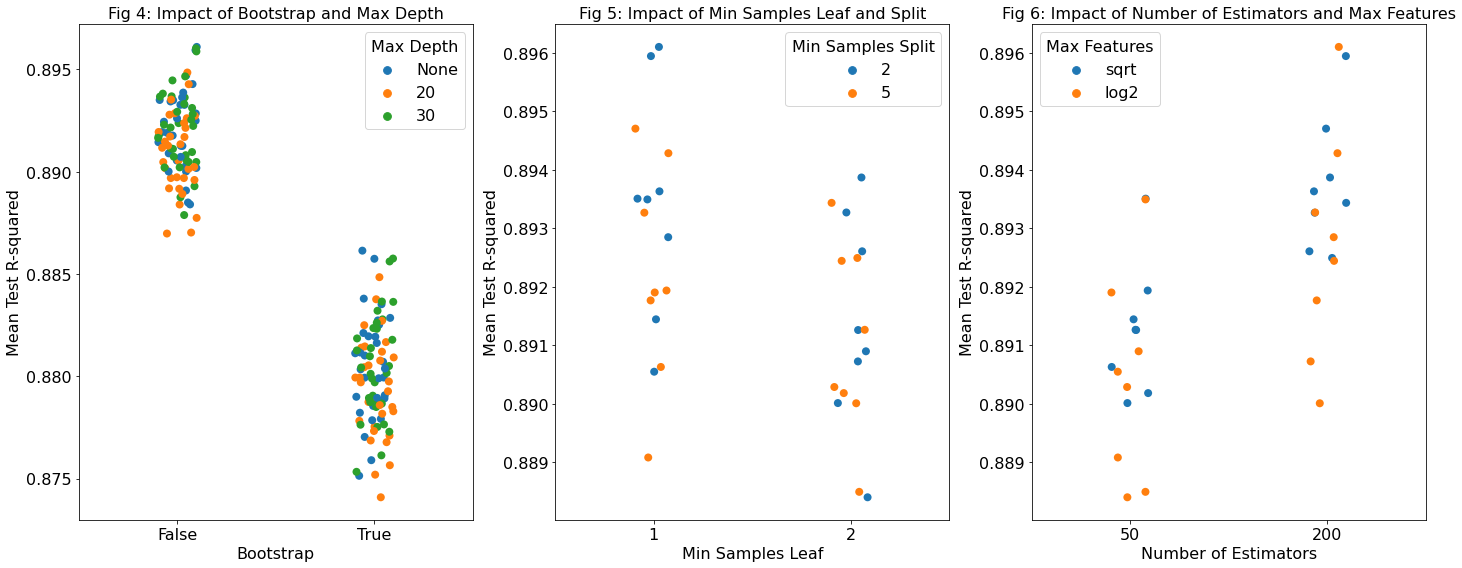

In [30]:
# create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# fig 4: Impact of Bootstrap and Max Depth
results['param_model__max_depth'] = results['param_model__max_depth'].astype(str)
sns.stripplot(data=results, x='param_model__bootstrap', y='mean_test_R-squared', hue='param_model__max_depth', ax=ax1, size=8)
ax1.set_title('Fig 4: Impact of Bootstrap and Max Depth', fontsize=16)
ax1.set_xlabel('Bootstrap', fontsize=16)
ax1.set_ylabel('Mean Test R-squared', fontsize=16)
legend1 = ax1.legend(title='Max Depth', fontsize=16)
legend1.get_title().set_fontsize(16) 
ax1.tick_params(axis='both', labelsize=16)

# fig 5: Impact of Min Samples Leaf and Split
filtered_results = results[(results['param_model__bootstrap'] == False) & (results['param_model__max_depth'] == 'None')]
sns.stripplot(data=filtered_results, x='param_model__min_samples_leaf', y='mean_test_R-squared', hue='param_model__min_samples_split', ax=ax2, size=8)
ax2.set_title('Fig 5: Impact of Min Samples Leaf and Split', fontsize=16)
ax2.set_xlabel('Min Samples Leaf', fontsize=16)
ax2.set_ylabel('Mean Test R-squared', fontsize=16)
legend2 = ax2.legend(title='Min Samples Split', fontsize=16)
legend2.get_title().set_fontsize(16) 
ax2.tick_params(axis='both', labelsize=16)

# fig 6: Impact of Number of Estimators and Max Features
sns.stripplot(data=filtered_results, x='param_model__n_estimators', y='mean_test_R-squared', hue='param_model__max_features', ax=ax3, size=8)
ax3.set_title('Fig 6: Impact of Number of Estimators and Max Features', fontsize=16)
ax3.set_xlabel('Number of Estimators', fontsize=16)
ax3.set_ylabel('Mean Test R-squared', fontsize=16)
legend3 = ax3.legend(title='Max Features', fontsize=16)
legend3.get_title().set_fontsize(16)  
ax3.tick_params(axis='both', labelsize=16)

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

Fine-tuning the parameters uncovered **comparable patterns and optimal values as seen in the baseline model**. Now, let's examine the impact of the polynomial degree.

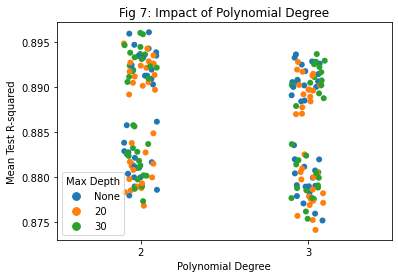

In [31]:
# fig 7: Impact of Number of Polynomial Degree
sns.stripplot(data=results, x='param_poly__degree', y='mean_test_R-squared', hue='param_model__max_depth', size=6)
plt.title('Fig 7: Impact of Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Test R-squared')
plt.legend(title='Max Depth')

In the chart above, it is evident that the **model achieves better scores with a polynomial degree of 2**. The observation that the model's performance decreases with a polynomial degree of 3, despite incorporating a larger set of potentially valuable features (including the cubic features), hints at the **possibility of overfitting**. This also suggests that even with a polynomial degree of 2, we might be introducing enough features to potentially lead to overfitting the model.

Now that we've fine-tuned the hyperparameters, we can **evaluate the model's performance on entirely unseen data**. For this purpose, we will train the model using the complete training-validation dataset and assess its predictions on the test set.

In [32]:
# fit the the best pipeline on the whole training-validation set
best_pipe_poly = grid_poly.best_estimator_
best_pipe_poly.fit(X_train[original_features], y_train)

# predict the target values for both the training-validation and test sets
y_train_pred = best_pipe_poly.predict(X_train[original_features])
y_test_pred = best_pipe_poly.predict(X_test[original_features])

Now, we can present the **metrics** for both the **complete training-validation set and the unseen test set**.

In [33]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, pd. DataFrame(best_pipe_poly[:-1].fit_transform(X_train[original_features])))

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 1.0000)
Test set adjusted R2 score: 0.8992)

Training set MSE score: -0.0000)
Test set MSE score: -0.1594)


Now, let's integrate the scores of the model with additional, polynomial features into the dataframe.

In [34]:
add_scores('polynomial')

In [35]:
RF_scores.loc[('Test', 'Adjusted R2')]

baseline      0.900769
polynomial    0.899222
Name: (Test, Adjusted R2), dtype: float64

A quick comparison of the adjusted R-squared values between the baseline and polynomial models indicates **no significant difference** in this metric **after introducing polynomial features**. This could imply that either the additional features don't enhance the predictive capacity of the model, or there might **already be an excess of features leading to overfitting**.

### _2A.2 Polynomial features + PCA_ ###

As a starting point for **approaching overfitting** let's try **dimentionality reduction** with PCA. We need a dataset with scaled features to be able to perform PCA. Therefore, let's augment the dataset with second-degree polynomial features and standardize them using StandardScaler.

In [36]:
# Create a PolynomialFeatures object with a degree of 2
poly2 = PolynomialFeatures(degree=2, include_bias=False)

# Apply the polynomial transformation to the training and test sets
X_train_poly2 = pd.DataFrame(poly2.fit_transform(X_train[original_features]))
X_test_poly2 = pd.DataFrame(poly2.transform(X_test[original_features]))

# Create a Scaler object
scaler = StandardScaler()

# Scale the features
X_train_poly2 = pd.DataFrame(scaler.fit_transform(X_train_poly2))
X_test_poly2 = pd.DataFrame(scaler.transform(X_test_poly2))

Let's fit the model and identify the number of components that contribute to **99% of the explained variance**.

In [37]:
# Import Principal Component Analysis module
from sklearn.decomposition import PCA

# Initialize PCA 
pca_poly2 = PCA()

# Fit and transform the data
X_train_poly2_pca = pca_poly2.fit_transform(X_train_poly2)

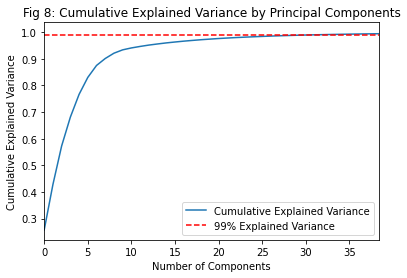

In [38]:
# Compute the explained variance ratio and cumulative explained variance
explained_var_ratio = pca_poly2.explained_variance_ratio_
cumulative_var_ratio = explained_var_ratio.cumsum()

# Find the number of principal components that explain at least 99% of the variance
n_components = np.argmax(cumulative_var_ratio >= 0.99) + 1

# Plot cumulative explained variance
plt.plot(cumulative_var_ratio, label='Cumulative Explained Variance')
plt.axhline(y=0.99, color='red', linestyle='--', label='99% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlim([0, 1.2*n_components]) 
plt.title('Fig 8: Cumulative Explained Variance by Principal Components')
plt.legend()
plt.show()

To capture **99% of the variance**, we **require the following number of components**:

In [39]:
n_components

32

Let's initialize PCA with the number of components determined above and fit the model to **obtain datasets with a reduced number of features**.

In [40]:
# Initialize PCA with the the number of features
pca_poly2 = PCA(n_components)

# Fit and transform the data
#X_train_poly2_pca = pd.DataFrame(pca_poly2.fit_transform(X_train_poly2))
#X_test_poly2_pca = pd.DataFrame(pca_poly2.transform(X_test_poly2))

# Or load saved trained model
pca_poly2 = joblib.load('models/pca_poly2.joblib')
X_train_poly2_pca = pd.DataFrame(pca_poly2.transform(X_train_poly2))
X_test_poly2_pca = pd.DataFrame(pca_poly2.transform(X_test_poly2))

Now that we have a dataset with a reduced number of components, let's define a **parameter grid**, and **optimize the model**.

In [41]:
# refine the polynomial order and tune hyperparameters specific to Random Forest
parameters = {
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False]
} 

In [42]:
#grid_poly2_pca = GridSearchCV(rf_model, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X_train_poly2_pca, y_train)

In [43]:
# save the GridSearchCV results
#joblib.dump(grid_poly2_pca, 'models/RF_poly2_pca_grid_result.joblib')

In [44]:
# load the GridSearchCV results
grid_poly2_pca = joblib.load('models/RF_poly2_pca_grid_result.joblib')

Let's examine the **outcomes of the optimization**.

In [45]:
# summary of the GridSearchCV
results_poly2 = pd.DataFrame(grid_poly2_pca.cv_results_)

# get the performance of the model
row = results_poly2['mean_test_MSE'].idxmax()
pm.get_best_scores(results_poly2, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.8859 (0.0027)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1769 (0.0031)


Now, let's **evaluate the model's performance on entirely unseen data**. For this purpose, we will train the model using the complete training-validation dataset and assess its predictions on the test set.

In [46]:
# fit the the best pipeline on the whole training-validation set
best_pipe_poly2_pca = grid_poly2_pca.best_estimator_
best_pipe_poly2_pca.fit(X_train_poly2_pca, y_train)

# predict the target values for both the training-validation and test sets
y_pred = best_pipe_poly2_pca.predict(X_train_poly2_pca)
y_test_pred = best_pipe_poly2_pca.predict(X_test_poly2_pca)

In [47]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_pred, y_test, y_test_pred, X_train_poly2_pca)

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 1.0000)
Test set adjusted R2 score: 0.8897)

Training set MSE score: -0.0000)
Test set MSE score: -0.1755)


Now, let's integrate the scores of the model into the dataframe.

In [48]:
add_scores('polynomial + PCA')

In [49]:
RF_scores.loc[('Test', 'Adjusted R2')]

baseline            0.900769
polynomial          0.899222
polynomial + PCA    0.889691
Name: (Test, Adjusted R2), dtype: float64

The results presented indicate that employing **PCA** for dimensionality reduction results in a **noticeable decline in the model's performance**. By prioritizing variance, PCA may discard valuable information pertinent to the target variable. Consequently, it retains components with high variance but limited relevance to the target variable, thereby compromising predictive accuracy. Due to these limitations, PCA will not be pursued during further feature integration in the RF model. Instead, an alternative approach, such as feature selection, will be explored.

_It was also checked, but not included in the table above what's the score of the model where PCA was used for dimentionality reduction on a dataset with polynomial features of degree 3 incorporated ($adjusted R^2$ = 0.8897). However there was no statistical difference observed between those models._

### 2.A.3 Polynomial features + feature selection with SelectKBest

Various measures have been implemented to **address overfitting**, including **regularization** through the optimization of parameters such as maximum depth, minimum samples required for a split, and minimum samples in a leaf node. Additionally, **dimensionality reduction using PCA** was attempted, but it did not enhance the model's performance. Another approach involves **feature selection** methods, which can be utilized to focus on the most informative features. This helps minimize the risk of overfitting by excluding irrelevant variables and noise from the modeling process.

Filter methods, such as **SelectKBest**, are a natural choice for feature selection in **models with numerous features**. Unlike wrapper methods, filter methods assess feature importance independently of the model, making them computationally efficient for large datasets. SelectKBest, utilizing statistical measures, **evaluates each feature's relevance to the target variable individually**, offering a quick and less computationally demanding way to identify informative features in high-dimensional spaces.

In [50]:
# Create a pipeline with feature selection and RF model 
pipeline = Pipeline([
    ('kbest', SelectKBest()),
    ('model', rf_model)
])

Let's assess the model's performance with the number of features ranging from 10 to the total number of features, which in the case of degree 2 polynomial features is 104, in increments of 10. Additionally, let's optimize the choice of scoring function. **_f regression_** assesses linear relationships between features and the target, using the F-statistic from ANOVA. In contrast, **_mutual_info_regression_** is more flexible, capturing both linear and non-linear relationships through mutual information.

In [51]:
parameters = {
    'model__n_estimators': [50],
    'model__bootstrap': [False],
    'model__max_features': ['sqrt', 'log2'],
    'kbest__k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 104],
    'kbest__score_func': [f_regression, mutual_info_regression]
} 

In [52]:
#grid_poly2_kbest = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X_train_poly2, y_train)

In [53]:
# save the GridSearchCV results
#joblib.dump(grid_poly2_kbest, 'models/RF_poly2_kbest_grid_result.joblib')

In [54]:
# load the GridSearchCV results
grid_poly2_kbest = joblib.load('models/RF_poly2_kbest_grid_result.joblib')

Let's examine the **outcomes of the optimization**.

In [55]:
# the best parameters
best_params = grid_poly2_kbest.best_params_
best_params

{'kbest__k': 90,
 'kbest__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>,
 'model__bootstrap': False,
 'model__max_features': 'sqrt',
 'model__n_estimators': 50}

In [56]:
# summary of the GridSearchCV
results_poly2_kbest = pd.DataFrame(grid_poly2_kbest.cv_results_)

row = results_poly2_kbest['mean_test_MSE'].idxmax()
pm.get_best_scores(results_poly2_kbest, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.8946 (0.0021)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1634 (0.0035)


To gain a more profound understanding of how the performance of the MLP model is affected by the number of features selected using SelectKBest, let's **visualize its performance across various feature counts**. Additionally, **we'll contrast these results with those obtained** using SelectKBest on a dataset featuring **degree 3 polynomial features** for comparison.

In [57]:
## load the GridSearchCV results obtained for degree 3 polynomial
grid_poly3_kbest = joblib.load('models/RF_poly_kbest_grid_result.joblib')
# summary of the GridSearchCV esults obtained for degree 3 polynomial
results_poly3_kbest = pd.DataFrame(grid_poly3_kbest.cv_results_)

In [58]:
## makes scoring function names more readible
# transform score function into more readible form for degree2 polynomial features
results_poly2_kbest['param_kbest__score_func'] = results_poly2_kbest['param_kbest__score_func'].astype(str)
results_poly2_kbest['param_kbest__score_func'] = results_poly2_kbest['param_kbest__score_func'].str.split().str[1]

# transform score function into more readible form for degree 3 polynomial features
results_poly3_kbest['param_kbest__score_func'] = results_poly3_kbest['param_kbest__score_func'].astype(str)
results_poly3_kbest['param_kbest__score_func'] = results_poly3_kbest['param_kbest__score_func'].str.split().str[1]

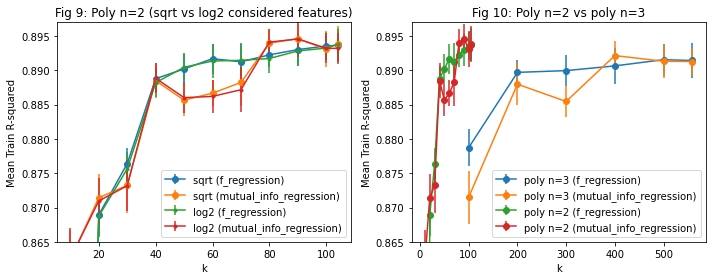

In [59]:
# compare influence of SelectKBest on degree 2 and 3 polynomial datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

### FIGURE 9
# Filter the results based on the function describing the number of features considered at each split
results_poly2_kbest_sqrt = results_poly2_kbest[results_poly2_kbest['param_model__max_features'] == 'sqrt']
results_poly2_kbest_log2 = results_poly2_kbest[results_poly2_kbest['param_model__max_features'] == 'log2']

# 1. with sqrt(n) features considered at each split
# group the results by the feature selection function name
grouped_results_sqrt = results_poly2_kbest_sqrt.groupby('param_kbest__score_func')

# Plot each group separately
for name, group in grouped_results_sqrt:
    ax1.errorbar(group['param_kbest__k'], group['mean_test_R-squared'], yerr=group['std_test_R-squared'], marker='o', label=f'sqrt ({name})')

# 2. with log2(n) features considered at each split
# group the results by the feature selection function name
grouped_results_log2 = results_poly2_kbest_log2.groupby('param_kbest__score_func')

# Plot each group separately
for name, group in grouped_results_log2:
    ax1.errorbar(group['param_kbest__k'], group['mean_test_R-squared'], yerr=group['std_test_R-squared'], marker='.', label=f'log2 ({name})')
    

### FIGURE 10
# Filter the results based on the function describing the number of features considered at each split
results_poly3_kbest_sqrt = results_poly3_kbest[results_poly3_kbest['param_model__max_features'] == 'sqrt']

# 1. Degree 3 polynomial features
# group the results by the feature selection function name
grouped_results_poly3 = results_poly3_kbest_sqrt.groupby('param_kbest__score_func')

# Plot each group separately
for name, group in grouped_results_poly3:
    ax2.errorbar(group['param_kbest__k'], group['mean_test_R-squared'], yerr=group['std_test_R-squared'], marker='o', label=f'poly n=3 ({name})')

# 2. Degree 2 polynomial features
# group the results by the feature selection function name
grouped_results_poly2 = results_poly2_kbest_sqrt.groupby('param_kbest__score_func')

# Plot each group separately
for name, group in grouped_results_poly2:
    ax2.errorbar(group['param_kbest__k'], group['mean_test_R-squared'], yerr=group['std_test_R-squared'], marker='o', label=f'poly n=2 ({name})')

### FIGURE PARAMETERS
# Set y limits for both subplots
ax1.set_ylim([0.865, 0.897])
ax2.set_ylim([0.865, 0.897])
    
# Display legends and labels for both subplots
ax1.set_title('Fig 9: Poly n=2 (sqrt vs log2 considered features)', fontsize=12)
ax1.legend()
ax1.set_xlabel('k')  # Label for the x-axis
ax1.set_ylabel('Mean Train R-squared')  # Label for the y-axis

ax2.set_title('Fig 10: Poly n=2 vs poly n=3', fontsize=12)
ax2.legend()
ax2.set_xlabel('k')  # Label for the x-axis
ax2.set_ylabel('Mean Train R-squared')  # Label for the y-axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In Figure 9, we can observe the following:
* There is no discrepancy in performance between selecting the number of features to consider when looking for the best split using 'sqrt' and 'log2'.
* Removing features based on the _f regression_ scoring function results in a gradual decline in the model's performance. On the other hand, employing the _mutual_info_regression_ scoring function
results in performance oscillation.
* The most favorable results were achieved when selecting the top 90 features using _mutual_info_regression_ as the scoring function, however, the observed change does not seem to have statistical significance.


In Figure 10, it's evident that: 
* The model performed better on the dataset initially comprised of degree 2 polynomial features.
* When SelectKBest reaches 100 features on the dataset with degree 3 polynomial features, the model's performance is notably worse as compared to the model with degree 2 polynomial features, which initially had a similar number of features.

To evaluate the impact of SelectKBest on the model's performance, let's examine its **scoring on an unseen test set**, utilizing 200 estimators.

In [60]:
# Access the 'model' step of the pipeline using named_steps and modify n_estimators
best_pipe_poly2_kbest = grid_poly2_kbest.best_estimator_
best_pipe_poly2_kbest.named_steps['model'].set_params(n_estimators=200)

# fit the the best pipeline on the whole training-validation set
best_pipe_poly2_kbest.fit(X_train_poly2, y_train)

# predict the target values for both the training-validation and test sets
y_train_pred = best_pipe_poly2_kbest.predict(X_train_poly2)
y_test_pred = best_pipe_poly2_kbest.predict(X_test_poly2)

In [61]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train[original_features])

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 1.0000)
Test set adjusted R2 score: 0.9009)

Training set MSE score: -0.0000)
Test set MSE score: -0.1579)


In [62]:
# integrate the scores into summary dataframe
add_scores('poly + KBest')

In [63]:
RF_scores.loc[('Test', 'Adjusted R2')]

baseline            0.900769
polynomial          0.899222
polynomial + PCA    0.889691
poly + KBest        0.900906
Name: (Test, Adjusted R2), dtype: float64

In the cell above, we can note that **the model utilizing SelectKBest scored comparably to the baseline model and the model utilizing all polynomial features**. However, SelectKBest, focusing on individual feature relevance, might exclude valuable features with lower correlation to the target. Univariate selection methods like SelectKBest may not always be optimal for Random Forest. The model itself inherently assesses feature importance, and this will be explored as the next step.

### 2.A.4 Polynomial features + feature selection with RFE

**Recursive Feature Elimination (RFE)** is a feature selection technique that **systematically removes the least important features from the model**. It iteratively fits the model and evaluates feature importance, eliminating the least significant features in each iteration. This process continues until the desired number of features is reached. 

#### _Degree 2 polynomial features_ ####

We already have **datasets that include polynomial features of degree 2**, comprising the following count of features:

In [64]:
# Set the initial number of features
initial_n_features = X_train_poly2.shape[1]
initial_n_features

104

We will employ Recursive Feature Elimination (RFE) to systematically reduce the number of features, varying from the total number of features to 10 in intervals of 10. Throughout the RFE process, a simple Random Forest model will serve as the estimator. Subsequently, after achieving the targeted reduced number of features, we will conduct a GridSearch to optimize hyperparameters. Metrics and their corresponding statistics will be computed based on the Random Forest model, utilizing 200 estimators.

In [65]:
# parameters to be used during GridSearchCV
parameters = {
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False]
    } 

In [66]:
# simple Random Forest model for feature importance estimation
rf_model_simple = RandomForestRegressor(
    n_estimators=50,
    max_features='sqrt',
    bootstrap=False,
    random_state=0
)

We will initiate the feature selection process using datasets that already incorporate polynomial features.

In [67]:
# datasets before RFE
X_train_rfe = X_train_poly2
X_test_rfe = X_test_poly2

Let's perform feature reduction and save both the outcomes of GridSearchCV and the datasets containing the reduced set of features.

In [ ]:
for num_features_to_select in [initial_n_features, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10]:
    
    # Initialize RFE with the current number of features to select
    rfe = RFE(rf_model_simple, n_features_to_select=num_features_to_select)

    # Fit RFE to the training data
    X_train_rfe = rfe.fit_transform(X_train_rfe, y_train)
    X_test_rfe = rfe.transform(X_test_rfe)
    
    # Train bigger model on reduced dataset
    grid = GridSearchCV(rf_model, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X_train_rfe, y_train)

    # save the GridSearchCV results
    grid_name = 'models/RF_poly2_rfe_' + str(num_features_to_select) + '.joblib'
    joblib.dump(grid, grid_name)
    
    # save train and test sets with selected features
    train_data_name = 'models/RF_poly2_rfe_' + str(num_features_to_select) + '_X_train.joblib'
    joblib.dump(X_train_rfe, train_data_name)

    test_data_name = 'models/RF_poly2_rfe_' + str(num_features_to_select) + '_X_test.joblib'
    joblib.dump(X_test_rfe, test_data_name)
    
    # Print or use the selected features
    print(f"Number of features selected: {num_features_to_select}")

Let's create a function that enables us to load datasets with a reduced number of features and predict target values for the unseen test set using the best pipeline identified during GridSearchCV.

In [ ]:
def get_rfe_scores(num_features_rfe, file_name):
    
    # load the saved grid
    grid_name = file_name + str(num_features_rfe) + '.joblib'
    grid_rfe = joblib.load(grid_name)
    
    # get the GridSearchCV results, select columns of interest and add number of features
    results = pd.DataFrame(grid_rfe.cv_results_)
    selected_results = results[['mean_fit_time', 'param_max_features', 'mean_train_R-squared', 'mean_test_R-squared', 'std_train_R-squared', 'std_test_R-squared', 'mean_train_MSE', 'mean_test_MSE', 'std_train_MSE', 'std_test_MSE']].copy()
    selected_results['n_features_rfe'] = num_features_rfe
    
    # load the reduced train and test sets
    train_data_name = file_name + str(num_features_rfe) + '_X_train.joblib'
    X_train_rfe = pd.DataFrame(joblib.load(train_data_name))

    test_data_name = file_name + str(num_features_rfe) + '_X_test.joblib'
    X_test_rfe = pd.DataFrame(joblib.load(test_data_name))
    
    # fit the the best pipeline on the whole training-validation set
    best_pipe = grid_rfe.best_estimator_
    best_pipe.fit(X_train_rfe, y_train)
    
    # Predict the target values for whole training and test sets
    y_train_pred = best_pipe.predict(X_train_rfe)
    y_test_pred = best_pipe.predict(X_test_rfe)
    
    # calculate adjusted-R2 and MSE scores
    pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train_rfe)
    
    # incorporate the scores in the DataFrame with results
    row_index = selected_results['mean_test_MSE'].idxmax()
    selected_results.loc[row_index, 'train_adjusted_R2'] = pm.train_adjusted_R2
    selected_results.loc[row_index, 'test_adjusted_R2'] = pm.test_adjusted_R2
    selected_results.loc[row_index, 'train_MSE'] = pm.train_MSE
    selected_results.loc[row_index, 'test_MSE'] = pm.test_MSE
    
    #return dataframe with hyperparameter values and performance metrics
    return selected_results

Let's combine the obtained results.

In [ ]:
results_poly2_rfe = pd.DataFrame()

for num_features_to_select in [initial_n_features, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10]: 
    
    # get the results obtained with RFE for a specific number of features
    results_rfe = get_rfe_scores(num_features_to_select, 'models/RF_poly2_rfe_')
    
    # add the results to DataFrame summarizing results
    results_poly2_rfe = pd.concat([results_poly2_rfe, results_rfe], axis = 0,  ignore_index=True)

In [68]:
# save the results
#joblib.dump(results_poly2_rfe, 'models/RF_poly2_rfe_results')
# load the results
results_poly2_rfe = joblib.load('models/RF_poly2_rfe_results')

Let's analyze the **results of the optimization**. The performance of the chosen model is as follows:

In [69]:
# get the performance of the model
row = results_poly2_rfe['mean_test_MSE'].idxmax()
pm.get_best_scores(results_poly2_rfe, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.8959 (0.0022)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1614 (0.0033)


Let's **visualize how the model's performance changes as we eliminate features**. Additionally, we'll compare these results with those obtained using a dataset that includes **degree 3 polynomial features**.

In [70]:
# load the results obtained on degree 3 polynomial dataset
results_poly3_rfe = joblib.load('models/RF_poly3_rfe_results')

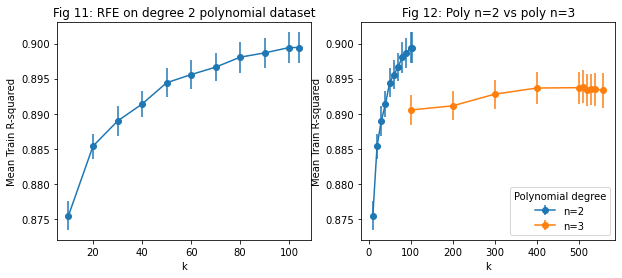

In [71]:
# compare influence of RFE on degree 2 and 3 polynomial datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Fig 11
ax1.errorbar(results_poly2_rfe['n_features_rfe'], results_poly2_rfe['test_adjusted_R2'], yerr=results_poly2_rfe['std_test_R-squared'], marker='o', label=name)

# Fig 12
results_poly3_rfe_filtered = results_poly3_rfe[results_poly3_rfe['param_max_features']=='sqrt']#results_kbest_sqrt = results_kbest[results_kbest['param_model__max_features'] == 'sqrt']
ax2.errorbar(results_poly2_rfe['n_features_rfe'], results_poly2_rfe['test_adjusted_R2'], yerr=results_poly2_rfe['std_test_R-squared'], marker='o', label='n=2')
ax2.errorbar(results_poly3_rfe_filtered['n_features_rfe'], results_poly3_rfe_filtered['test_adjusted_R2'], yerr=results_poly3_rfe_filtered['std_test_R-squared'], marker='o', label='n=3')

# Display legends and labels
ax1.set_title('Fig 11: RFE on degree 2 polynomial dataset')
ax1.set_xlabel('k')  # Label for the x-axis
ax1.set_ylabel('Mean Train R-squared')  # Label for the y-axis

ax2.set_title('Fig 12: Poly n=2 vs poly n=3', fontsize=12)
ax2.legend(title='Polynomial degree', loc='lower right')
ax2.set_xlabel('k')  # Label for the x-axis
ax2.set_ylabel('Mean Train R-squared')  # Label for the y-axis

plt.show()

In Figure 11, we notice a **gradual decrease in the model's performance** as features are removed using RFE from the dataset containing degree 2 polynomial features.

In Figure 12, it's evident that the **model exhibited better performance on the dataset originally composed of degree 2 polynomial features**. However, for the model constructed **with degree 3 polynomial features, RFE provides a marginal enhancement**, with the model achieving its highest score when approximately 10% of the features are eliminated.

Next, we'll incorporate the **performance results for the test set** and conduct a comprehensive **comparison of all approaches employed to address overfitting**.

In [72]:
pm.train_adjusted_R2 = results_poly2_rfe.loc[row, 'train_adjusted_R2']
pm.test_adjusted_R2 = results_poly2_rfe.loc[row, 'test_adjusted_R2']
pm.train_MSE = results_poly2_rfe.loc[row, 'train_MSE']
pm.test_MSE = results_poly2_rfe.loc[row, 'test_MSE']

In [73]:
# integrate the scores into summary dataframe
add_scores('poly + RFE')

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

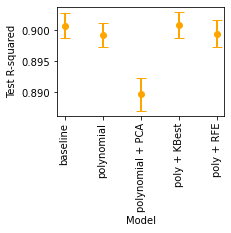

In [74]:
# compare the existing models
columns = ['baseline', 'polynomial', 'polynomial + PCA', 'poly + KBest', 'poly + RFE']

# select R2 scores with std of the test set
df = RF_scores[columns].loc[(RF_scores.index.get_level_values(0) == 'Test') & (RF_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std','CV_R2']))]
df = df.droplevel(0).T

# plot data with std
plt.figure(figsize=(3, 2))
plt.errorbar(x=df.index, y=df['Adjusted R2'], yerr=df['CV_R2_std'], fmt='o', color='orange', capsize=5, elinewidth=2)

plt.xlabel('Model')
plt.ylabel('Test R-squared')
plt.xticks(rotation=90)

The analyses above indicate that none of the strategies implemented to mitigate potential overfitting resulted in an improvement in the model's performance. Furthermore, there were **no statistically significant differences observed between the majority of the models**. However, one model notably **underperformed**, specifically the model where **PCA** was utilized for dimensionality reduction.

### 2B Rational difference features ###

### _2B.1 Rational difference features_ ###

For now, let's set aside the polynomial features and focus solely on incorporating the features referred to as _rational differences_.  The motivation behind engineering features of this nature is rooted in the common observation that **models often struggle to synthesize expressions of this type effectively** <font color='gray'>_(J. Heaton, "An empirical analysis of feature engineering for predictive modeling," SoutheastCon 2016, Norfolk, VA, USA, 2016, pp. 1-6, doi: 10.1109/SECON.2016.7506650)_</font>.

Rational differences refer to equations written in this form:

$$\frac{a-b}{c}$$

Let's assess the impact of including these features on the performance of the linear model...

In [75]:
parameters = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
} 

In [76]:
#grid_diff = GridSearchCV(rf_model, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X_train, y_train)

In [77]:
# save the GridSearchCV results
#joblib.dump(grid_diff, 'RF_diff_grid_result_extended.joblib')

In [78]:
# load the results
grid_diff = joblib.load('RF_diff_grid_result_extended.joblib')

... and display the results

In [79]:
best_params = grid_diff.best_params_
best_params

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [80]:
# summary of the GridSearchCV
results = pd.DataFrame(grid_diff.cv_results_)

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.8944 (0.0028)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1637 (0.0035)


To **assess the model's performance on entirely unseen data**, we will train the model using the complete training-validation dataset and make predictions for the target values.

In [81]:
# fit the the best pipeline on the whole training-validation set
best_pipe_diff = grid_diff.best_estimator_
best_pipe_diff.fit(X_train, y_train)

# predict the target values for both the training-validation and test sets
y_train_pred = best_pipe_diff.predict(X_train)
y_test_pred = best_pipe_diff.predict(X_test)

The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [82]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train)

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 1.0000)
Test set adjusted R2 score: 0.8953)

Training set MSE score: -0.0000)
Test set MSE score: -0.1649)


Let's contrast these values with those from the previous models.

In [83]:
add_scores('rational_diff')

In [84]:
RF_scores.loc[('Test', 'Adjusted R2')]

baseline            0.900769
polynomial          0.899222
polynomial + PCA    0.889691
poly + KBest        0.900906
poly + RFE          0.899431
rational_diff       0.895299
Name: (Test, Adjusted R2), dtype: float64

A minor decline in the model's performance is likely attributable to the phenomenon that adding new features leads to overtraining of the model.

### _2B.2 Rational difference features + feature selection with RFE_ ###

Let's determine if the more sophisticated of the two previously tested feature selection methods enhances the performance of the model with rational difference features.

The training set, __X_train, already incorporates rational difference features__, and it consists of the following number of features:

In [85]:
# Set the initial number of features
initial_n_features = X_train.shape[1]
initial_n_features

149

Again, we will employ Recursive Feature Elimination (RFE) to systematically reduce the number of features, varying from 10 to the total number of features in intervals of 10. Throughout the RFE process, a default Random Forest model will serve as the estimator. Subsequently, after achieving the targeted reduced number of features, we will conduct a GridSearch to optimize hyperparameters. Metrics and their corresponding statistics will be computed based on the Random Forest model, utilizing 200 estimators.

In [86]:
parameters = {
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False]
    } 

We will initiate the feature selection process using datasets that already incorporate rational difference features.

In [87]:
X_train_rfe = X_train
X_test_rfe = X_test

Let's perform feature reduction and save both the outcomes of GridSearchCV and the datasets containing the reduced set of features.

In [ ]:
for num_features_to_select in [initial_n_features, 140, 130, 120, 110, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10]:
    
    # Initialize RFE with the current number of features to select
    rfe = RFE(rf_model_simple, n_features_to_select=num_features_to_select)

    # Fit RFE to the training data
    X_train_rfe = rfe.fit_transform(X_train_rfe, y_train)
    X_test_rfe = rfe.transform(X_test_rfe)
    
    # Train bigger model on reduced dataset
    grid = GridSearchCV(rf_model, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X_train_rfe, y_train)

    # save the GridSearchCV results
    grid_name = 'models/RF_diff_rfe_' + str(num_features_to_select) + '.joblib'
    joblib.dump(grid, grid_name)
    
    # save train and test sets with selected features
    train_data_name = 'models/RF_diff_rfe_' + str(num_features_to_select) + '_X_train.joblib'
    joblib.dump(X_train_rfe, train_data_name)

    test_data_name = 'models/RF_diff_rfe_' + str(num_features_to_select) + '_X_test.joblib'
    joblib.dump(X_test_rfe, test_data_name)
    
    # Print or use the selected features
    print(f"Number of features selected: {num_features_to_select}")

Let's consolidate all the outcomes from Recursive Feature Elimination (RFE).

In [ ]:
results_diff_rfe = pd.DataFrame()

for num_features_to_select in [initial_n_features, 140, 130, 120, 110, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10]:
    
    # get the results obtained with RFE for a specific number of features
    results = get_rfe_scores(num_features_to_select, 'models/RF_diff_rfe_')
    
    # add the results to DataFrame summarizing results
    results_diff_rfe = pd.concat([results_diff_rfe, results], axis = 0,  ignore_index=True)

In [88]:
# load the results
results_diff_rfe = joblib.load('models/RF_diff_rfe_results')

Let's analyze the results of the optimization. The performance of the chosen model is as follows:

In [89]:
# get the performance of the model
row = results_diff_rfe['mean_test_MSE'].idxmax()
pm.get_best_scores(results_diff_rfe, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.8944 (0.0025)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1637 (0.0031)


To gain a deeper insight into how the number of features impacts the performance of the random forest model, let's **visualize the performance changes as we eliminate features**.|

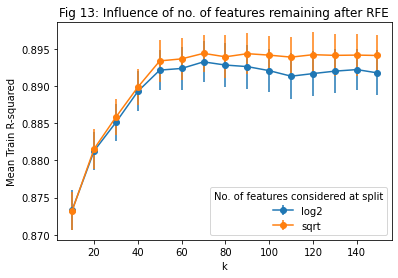

In [90]:
# Filter out the results obtained with 'auto' function used to select the number of features considered at each split
results_diff_rfe_filtered = results_diff_rfe[results_diff_rfe['param_max_features'].isin(['sqrt', 'log2'])]#results_kbest_sqrt = results_kbest[results_kbest['param_model__max_features'] == 'sqrt']

# group the results by the feature selection function used to select the number of features considered at each split
grouped_results = results_diff_rfe_filtered.groupby('param_max_features')

# Plot each group separately
for name, group in grouped_results:
    plt.errorbar(group['n_features_rfe'], group['mean_test_R-squared'], yerr=group['std_test_R-squared'], marker='o', label=name)

# Display legends and labels
plt.title('Fig 13: Influence of no. of features remaining after RFE')
plt.legend(title='No. of features considered at split', loc='lower right')
plt.xlabel('k')  # Label for the x-axis
plt.ylabel('Mean Train R-squared')  # Label for the y-axis

plt.show()

In the plot above, we can see that only about 50 features seem to be essential, and about 100 features could be removed without decreasing the model's performance. The highest score was observed for 70 features included, although the differences in the range 50 - 149 features are not statistically significant.


it is evident that **decreasing the number of features through Recursive Feature Elimination (RFE) does not enhance the model's performance**. Additionally, it becomes apparent that the optimal number of features for identifying the **best split** is determined to be **sqrt(n)**.

Next, we'll incorporate the **performance results for the test set** and conduct a comprehensive **comparison of all approaches employed to address overfitting**.

In [91]:
pm.train_adjusted_R2 = results_diff_rfe.loc[row, 'train_adjusted_R2']
pm.test_adjusted_R2 = results_diff_rfe.loc[row, 'test_adjusted_R2']
pm.train_MSE = results_diff_rfe.loc[row, 'train_MSE']
pm.test_MSE = results_diff_rfe.loc[row, 'test_MSE']

In [92]:
# integrate the scores into summary dataframe
add_scores('diff + RFE')

In [93]:
RF_scores.loc[('Test', 'Adjusted R2')]

baseline            0.900769
polynomial          0.899222
polynomial + PCA    0.889691
poly + KBest        0.900906
poly + RFE          0.899431
rational_diff       0.895299
diff + RFE          0.895961
Name: (Test, Adjusted R2), dtype: float64

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

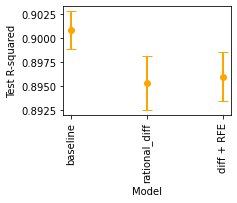

In [94]:
# compare the existing models
columns = ['baseline', 'rational_diff', 'diff + RFE']

# select R2 scores with std of the test set
df = RF_scores[columns].loc[(RF_scores.index.get_level_values(0) == 'Test') & (RF_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))]
df = df.droplevel(0).T

# plot data with std
plt.figure(figsize=(3, 2))
plt.errorbar(x=df.index, y=df['Adjusted R2'], yerr=df['CV_R2_std'], fmt='o', color='orange', capsize=5, elinewidth=2)
plt.xlabel('Model')
plt.ylabel('Test R-squared')
plt.xticks(rotation=90)

While RFE resulted in a slight enhancement of the model containing rational difference features, the observed change lacks statistical significance. However, both models still perform notably worse than the reference "baseline" model.

### 2C. Additional features and scalers

### _2C.1 Introducing additional features, various transformers and scalers_ ###

Finally, we'll construct a model that considers both polynomial and rational difference features, as well as power transformers, which were suggested during Exploratory Data Analysis and aim to enhance the model's performance.

In [95]:
# transformer applying PolynomialFeatures and PowerTransformer to 13 original features
transformers = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), original_features),
        ('power', PowerTransformer(), original_features)
    ],
    remainder='passthrough'
)

In [96]:
# make a pipeline that includes the aforementioned transformers, scalers, and the random forest model
steps = list()
steps.append(('transformers', transformers))
steps.append(('model', rf_model))
pipeline = Pipeline(steps=steps)

The parameters that require tuning include the polynomial degree and the choice of the function determining number of features to consider when looking for the best split.

In [97]:
parameters = {
    'transformers__poly__degree': [2, 3],
    'model__n_estimators': [50],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [False]
} 

Let's optimize the model...

In [98]:
#grid_features_scalers = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X, y)

In [99]:
# save the GridSearchCV results
#joblib.dump(grid_features_scalers, 'RF_features_scalers_grid_result_extended.joblib')

In [100]:
# load the results
grid_features_scalers = joblib.load('RF_features_scalers_grid_result_extended.joblib')

... and have a look at the results of the optimization.

In [101]:
# the best parameters
best_params = grid_features_scalers.best_params_
best_params

{'model__bootstrap': False,
 'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50,
 'scale': StandardScaler(),
 'transformers__poly__degree': 2}

Once more, the model trained on the dataset featuring **degree 2 polynomial features exhibited superior performance**.

In [102]:
# summary of the GridSearchCV
results = pd.DataFrame(grid_features_scalers.cv_results_)

# get the performance of the model
row = results['mean_test_MSE'].idxmax()
pm.get_best_scores(results, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.9006 (0.0028)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1541 (0.0038)


To **assess the model's performance on entirely unseen data**, we will train the model using the complete training-validation dataset and make predictions for the target values.

In [103]:
# fit the the best pipeline on the whole training-validation set
best_pipe_features_scalers = grid_features_scalers.best_estimator_
best_pipe_features_scalers.set_params(model__n_estimators=200)
best_pipe_features_scalers.fit(X_train, y_train)

# predict the target values for both the training-validation and test sets
y_train_pred = best_pipe_features_scalers.predict(X_train)
y_test_pred = best_pipe_features_scalers.predict(X_test)

The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [104]:
# calculate adjusted-R2 and MSE scores
pm.get_test_scores(y_train, y_train_pred, y_test, y_test_pred, X_train)

# display the above scores
pm.print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 1.0000)
Test set adjusted R2 score: 0.9041)

Training set MSE score: -0.0000)
Test set MSE score: -0.1511)


Let's provide an overview of all the models we've developed thus far.

In [105]:
add_scores('all_features')

RF_scores.loc[([('Test', 'Adjusted R2'), ('Test', 'CV_R2_std')])]

Before we contrast the model incorporating all developed features with the baseline model, let's assess whether we can further optimize its performance using RFE.

### _2C.2 All features + feature selection with RFE_

Let's employ the transformer defined in the preceding section to generate a dataset encompassing all the features developed thus far. This dataset consists of the following number of features:

In [106]:
X_train_all = transformers.fit_transform(X_train)
X_test_all = transformers.transform(X_test)

In [107]:
# Set the initial number of features
initial_n_features = X_train_all.shape[1]
initial_n_features

253

Again, we will employ Recursive Feature Elimination (RFE) to systematically reduce the number of features.

In [108]:
parameters = {
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False]
    } 

In [109]:
X_train_rfe = X_train_all
X_test_rfe = X_test_all

In [ ]:
for num_features_to_select in [initial_n_features, 250, 240, 230, 220, 210, 200, 180, 160, 140, 120, 100, 80, 60, 40, 20]:
    
    # Initialize RFE with the current number of features to select
    rfe = RFE(rf_model_simple, n_features_to_select=num_features_to_select)

    # Fit RFE to the training data
    X_train_rfe = rfe.fit_transform(X_train_rfe, y_train)
    X_test_rfe = rfe.transform(X_test_rfe)
    
    # Train bigger model on reduced dataset
    grid = GridSearchCV(rf_model, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True, verbose=2).fit(X_train_rfe, y_train)

    # save the GridSearchCV results
    grid_name = 'models/RF_all2_rfe_' + str(num_features_to_select) + '.joblib'
    joblib.dump(grid, grid_name)
    
    # save train and test sets with selected features
    train_data_name = 'models/RF_all2_rfe_' + str(num_features_to_select) + '_X_train.joblib'
    joblib.dump(X_train_rfe, train_data_name)

    test_data_name = 'models/RF_all2_rfe_' + str(num_features_to_select) + '_X_test.joblib'
    joblib.dump(X_test_rfe, test_data_name)
    
    # Print or use the selected features
    print(f"Number of features selected: {num_features_to_select}")

Let's consolidate all the outcomes from Recursive Feature Elimination (RFE).

In [ ]:
results_all2_rfe = pd.DataFrame()

for num_features_to_select in [initial_n_features, 250, 240, 230, 220, 210, 200, 180, 160, 140, 120, 100, 80, 60, 40, 20]:
    
    # get the results obtained with RFE for a specific number of features
    results = get_rfe_scores(num_features_to_select, 'models/RF_all2_rfe_')
    
    # add the results to DataFrame summarizing results
    results_all2_rfe = pd.concat([results_all2_rfe, results], axis = 0,  ignore_index=True)

In [110]:
# save the results
#joblib.dump(results_all2_rfe, 'models/RF_all2_rfe_results.joblib')
# load the results
results_all2_rfe = joblib.load('models/RF_all2_rfe_results.joblib')

Let's analyze the results of the optimization. The performance of the chosen model is as follows:

In [111]:
# get the performance of the model
row = results_all2_rfe['mean_test_MSE'].idxmax()
pm.get_best_scores(results_all2_rfe, row)

# print the information about the performance
pm.print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 1.0000 (0.0000)
Test set R2 score: 0.9023 (0.0022)

Training set MSE score: -0.0000 (0.0000)
Test set MSE score: -0.1515 (0.0028)


To gain deeper insight into the impact of RFE on the model's performance, let's **visualize how it changes with a decreasing number of features**. Additionally, we'll compare these results with those obtained for the dataset containing **degree 3 polynomial features**.

In [112]:
# load the results obtained for the degree 3 polynomial features dataset
results_all3_rfe = joblib.load('models/RF_all3_rfe_results.joblib')

Text(0, 0.5, 'Mean Train R-squared')

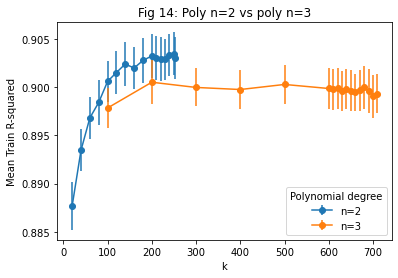

In [113]:
# drop lines with NaNs in both datasets
results_all2_rfe_filtered = results_all2_rfe.dropna()
results_all3_rfe_filtered = results_all3_rfe.dropna()

# plot data
plt.errorbar(results_all2_rfe_filtered['n_features_rfe'], results_all2_rfe_filtered['test_adjusted_R2'], yerr=results_all2_rfe_filtered['std_test_R-squared'], marker='o', label='n=2')
plt.errorbar(results_all3_rfe_filtered['n_features_rfe'], results_all3_rfe_filtered['test_adjusted_R2'], yerr=results_all3_rfe_filtered['std_test_R-squared'], marker='o', label='n=3')

# Display legends and titles
plt.title('Fig 14: Poly n=2 vs poly n=3', fontsize=12)
plt.legend(title='Polynomial degree', loc='lower right')
plt.xlabel('k')  # Label for the x-axis
plt.ylabel('Mean Train R-squared')  # Label for the y-axis

In Figure 14, we notice a **gradual decrease in the model's performance** as features are removed using RFE from the dataset containing degree 2 polynomial features. It is also evident that the **model exhibited better performance on the dataset originally composed of degree 2 polynomial features**. However, for the model constructed **with degree 3 polynomial features, RFE provides a marginal enhancement**, with the model achieving its highest score when only ~30% of the original features are left, which is close to the number of features in the degree 2 polynomial dataset.

Next, we'll incorporate the **performance results for the test set** and conduct a comprehensive **comparison of all approaches employed to address overfitting**.

In [114]:
pm.train_adjusted_R2 = results_all2_rfe.loc[row, 'train_adjusted_R2']
pm.test_adjusted_R2 = results_all2_rfe.loc[row, 'test_adjusted_R2']
pm.train_MSE = results_all2_rfe.loc[row, 'train_MSE']
pm.test_MSE = results_all2_rfe.loc[row, 'test_MSE']

In [115]:
# integrate the scores into summary dataframe
add_scores('all + RFE')

In [116]:
RF_scores.loc[('Test', 'Adjusted R2')]

baseline            0.900769
polynomial          0.899222
polynomial + PCA    0.889691
poly + KBest        0.900906
poly + RFE          0.899431
rational_diff       0.895299
diff + RFE          0.895961
all_features        0.904111
all + RFE           0.903434
Name: (Test, Adjusted R2), dtype: float64

([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

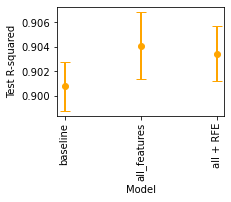

In [117]:
# compare the existing models
columns = ['baseline', 'all_features', 'all + RFE']

# select R2 scores with std of the test set
df = RF_scores[columns].loc[(RF_scores.index.get_level_values(0) == 'Test') & (RF_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std','CV_R2']))]
df = df.droplevel(0).T

# plot data with std
plt.figure(figsize=(3, 2))
plt.errorbar(x=df.index, y=df['Adjusted R2'], yerr=df['CV_R2_std'], fmt='o', color='orange', capsize=5, elinewidth=2)

plt.xlabel('Model')
plt.ylabel('Test R-squared')
plt.xticks(rotation=90)

The **model incorporating all features and scalers performs slightly better than the baseline model**, as observed above. RFE does not provide any improvement in performance.

Let's go back to the fitted data from the model with **all features included, prior to the application of RFE, as it yielded the best results**.

In [118]:
# fit the the best pipeline on the whole training-validation set
best_pipe_features_scalers = grid_features_scalers.best_estimator_
best_pipe_features_scalers.set_params(model__n_estimators=200)
best_pipe_features_scalers.fit(X_train, y_train)

# predict the target values for both the training-validation and test sets
y_train_pred = best_pipe_features_scalers.predict(X_train)
y_test_pred = best_pipe_features_scalers.predict(X_test)

Visual representation of the model's fit to the **training-validation set**.

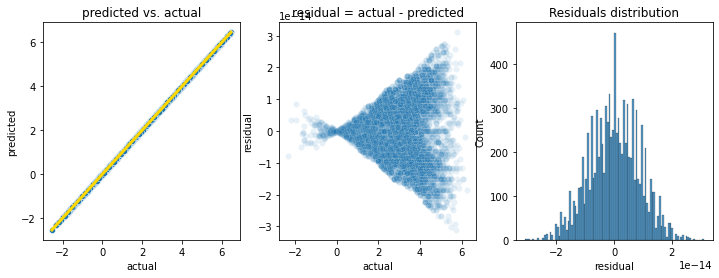

In [119]:
pm.visualize_fit(y_train, y_train_pred)

Visual representation of the model's fit to the **unseen test set**.

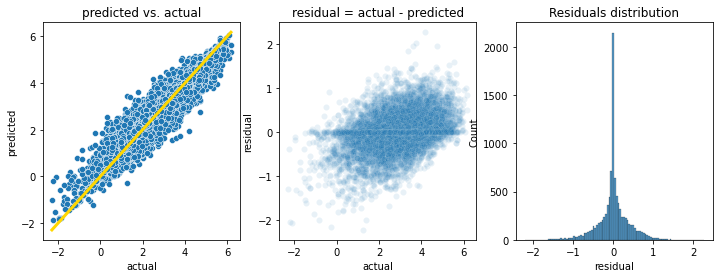

In [120]:
pm.visualize_fit(y_test, y_test_pred)

The visual assessment of the plots above doesn't reveal any improvement in the model compared to the baseline model. Let's then compare the performance metrics of all developed models.

### 3. Summary

### 3.A. An Approach to Addressing Uncertainties

The comparison between the regular R-squared (R²) and the adjusted R-squared (adjusted R²) reveals a **slightly higher**, but still **comparable**, value for the **adjusted R²**. Adjusted R² calculates a correction based on both the **number of features and the number of samples**, which makes the **results more comparable** between models containing different numbers of features.


The scores' **uncertainty is assessed exclusively during GridSearchCV**. Nevertheless, we assume that the **uncertainties associated with the values acquired for the unseen test data are of a comparable order of magnitude, and we will utilize them for the plots**.

On one hand, the metric's value for the unseen data is less accurate because it's a single value, in contrast to an average of 10 measurements as in GridSearchCV. On the other hand, the model used to obtain the target values for the unseen test data was trained on a slightly larger dataset. Additionally, the unseen test set itself is approximately twice as large as the test sets used in GridSearchCV.

### 3.B Influence of engineered features and dimentionality reduction

Let's evaluate the model's evolution by analyzing the Adjusted R2 values at critical stages, encompassing feature engineering and dimensionality reduction. Adjusted R2 enables comparison across models with different feature counts. 

In [121]:
# select Adjusted R2 values together with std values
metrics_test = RF_scores.loc[(RF_scores.index.get_level_values(0) == 'Test')&(RF_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))].droplevel(0).T
metrics_test['Set'] = 'Test'
metrics_train = RF_scores.loc[(RF_scores.index.get_level_values(0) == 'Train')&(RF_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))].droplevel(0).T
metrics_train['Set'] = 'Train'
metrics = pd.concat([metrics_train, metrics_test])

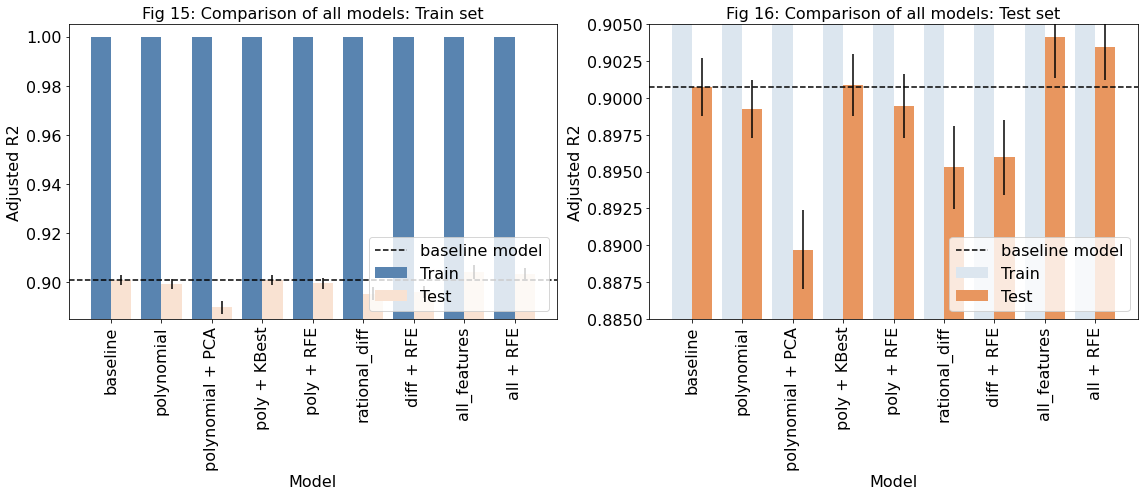

In [122]:
# set the figure size
plt.figure(figsize=(16, 7))

# Define the palette
palette = {'Train': '#4a84be', 'Test': '#ff9248'}

# Modify the alpha value for the 'Test' color
palette['Test'] = sns.set_hls_values(palette['Test'], l=0.9)  # Adjust the lightness value as needed

# create the first bar plot with adjusted y-axis limits
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=metrics, x=metrics.index, y='Adjusted R2', hue='Set', palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax1.patches]
y_coords = [p.get_height() for p in ax1.patches]
ax1.errorbar(x=x_coords, y=y_coords, yerr=metrics['CV_R2_std'], fmt="none", c="k")
ax1.axhline(y=metrics.loc['baseline', 'Adjusted R2'].values[1], color='black', linestyle='--', label='baseline model')
ax1.set_title('Fig 15: Comparison of all models: Train set', fontsize=16)
plt.xlabel('Model', fontsize=16)  
plt.ylabel('Adjusted R2', fontsize=16) 
plt.ylim(0.885, 1.005)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower right', fontsize=16)

# Modify the alpha value for the 'Train' color
palette = {'Train': '#4a84be', 'Test': '#ff9248'}
palette['Train'] = sns.set_hls_values(palette['Train'], l=0.9)  # Adjust the lightness value as needed

# create the second bar plot with different y-axis limits
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=metrics, x=metrics.index, y='Adjusted R2', hue='Set', palette=palette)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax2.patches]
y_coords = [p.get_height() for p in ax2.patches]
ax2.errorbar(x=x_coords, y=y_coords, yerr=metrics['CV_R2_std'], fmt="none", c="k")
ax2.axhline(y=metrics.loc['baseline', 'Adjusted R2'].values[1], color='black', linestyle='--', label='baseline model')
ax2.set_title('Fig 16: Comparison of all models: Test set', fontsize=16)
plt.xlabel('Model', fontsize=16)  
plt.ylabel('Adjusted R2', fontsize=16) 
plt.ylim(0.885, 0.905)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower right', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

* In Figure 15, it's apparent that regardless of the number of features included, all models exhibit perfect performance on the **training set**.  


* Figure 16 illustrates that **incorporating polynomial features has negligible impact** on the model's performance **on the test set**. Specifically, the addition of degree 2 polynomial features doesn't affect the model's performance, while the introduction of degree 3 polynomial features even leads to a decline. The **inclusion of rational difference features also diminishes the model's performance**. **Remarkably, the model incorporating all feature types (polynomial, rational difference, and power-transformed) achieves slightly higher score** comparing to the baseline model. However, from this analysis, it's evident that the **inclusion of engineered features has minimal effect on the model's performance**.


* The **application of PCA**, optimized to explain 99% of the original variance, results in a significant performance **decrease**


* Feature **selection methods such as SelectKBest and RFE do not enhance model performance in most cases**. Although some slight improvements were observed when RFE was applied to a dataset with degree 3 polynomial features incorporated, they were not statistically significant.

In [123]:
# save Linear Regression's metrics for further comparison
RF_scores.to_csv('RF_scores.csv', index=True)